# Interactive tools
> Very helpful interactive tools

In [1]:
# default_exp widgets

In [12]:
# export
import pandas as pd
import numpy as np
from forgebox.df import PandasDisplay
from forgebox.html import list_group, list_group_kv
from typing import Callable, List, Tuple, Set, Dict, Any
from ipywidgets import (
    IntSlider, FloatSlider, Text, Textarea, Layout,
    Output, HBox, VBox, Button,
    Select, SelectMultiple,
    Dropdown, Checkbox,
    IntProgress, HTML, interact, interact_manual
)

In [8]:
# export
def display_df(df):display(df)

def search_box(df,columns,manual = False,max_rows = 10,callback = display_df):
    """
    create a search box based on dataframe
    df: pandas dataframe
    columns: str, dataframe field name
    manual: bool, search the dataframe on when click the button(manual=True), 
        or on keypress reaction to inputbox (manual=False), default False
    max_rows:int, max rows of show result, default 10
    callback: python callable, discribe the action you want to put on 
        search result (a filtered dataframe), default is to display the dataframe
    """
    from ipywidgets import interact,interact_manual
    from IPython.display import HTML
    
    intera = interact_manual if manual else interact

    @intera
    def search(KeyWord = "",):
        for col in columns:
            result = df[col].fillna("NaN Value").str.contains(KeyWord)
            if sum(result)>0:
                with PandasDisplay(max_colwidth=0,max_rows=max_rows):
                    display(HTML(f"<h3>\"{KeyWord}\" matched on column:[{col}]</h3>"))
                    callback(df[result].head(max_rows))
                    return 
        print(f"Nothing found on any column on keyword:{KeyWord}")
        return 

## Search text within dataframe columns

We can have any dataframe we like:

In [29]:
df = pd.read_csv("~/Downloads/mesh_keywords_202004201804.csv").head(2000)

Put the dataframe and target column names into the ```search_box()```

In [4]:
search_box(df,columns=["keyword",])

interactive(children=(Text(value='', description='KeyWord'), Output()), _dom_classes=('widget-interact',))

If your dataframe is slightly huge, and slow to respond, you can use ```manual=True``` to turn off the auto keypress response

In [5]:
search_box(df,columns=["keyword",],manual=True)

interactive(children=(Text(value='', description='KeyWord'), Button(description='Run Interact', style=ButtonSt…

## Interactive pagination

In [6]:
# export
def paginate(df,page_len = 20):
    """
    Paginate dataframe in jupyter notebook interactively
    Like you can flip through the page
    """
    from ipywidgets import interact,interact_manual
    from IPython.display import display,HTML
    pages = len(df)//page_len
    @interact
    def preview(page = (0,pages)):
        display(HTML(f"<h4>page:{page}/{pages}</4>"))
        end = (page+1)*page_len
        display(df.head(end).tail(page_len))

In [7]:
paginate(df)

interactive(children=(IntSlider(value=50, description='page'), Output()), _dom_classes=('widget-interact',))

## SingleButton widget

A single button widget

It's like interactive_manual with callback

You can make an fully interactive featured widgets if there is only one button to get new page
    
### Example
    
```python
@SingleButton(callback=execute_sql, btn_text:"run command", btn_style="primary")
def makeup_some_sql(
    table={"typing":list, "options":["table_a", "table_b"]},
    limit={"typing":int, "max":1000, "step":10, "default":100},
):
    return f"select * from {table} limit {limit}"
```

In [11]:
# export
def make_hboxes(
    *widgets,
    sections: int=2
) -> List[HBox]:
    """
    Make a list of HBox, with each hbox
        contans {sections} of widgets at most
    widgets: widget from ipywidgets
    sections: int
    """
    hbox_list = []
    hbox_inner=[]
    for idx, widget in enumerate(widgets):
        hbox_inner.append(widget)
        if idx%sections==sections-1:
            hbox_list.append(HBox(hbox_inner))
            hbox_inner=[]
    if len(hbox_inner)>0:
        hbox_list.append(HBox(hbox_inner))
    return hbox_list

class SingleButton:
    """
    A single button widget
    It's like interactive_manual with callback
    
    ## Example
    
    ```python
    @SingleButton(callback=execute_sql, btn_text:"run command", btn_style="primary")
    def makeup_some_sql(
        table={"typing":list, "options":["table_a", "table_b"]},
        limit={"typing":int, "max":1000, "step":10, "default":100},
    ):
        return f"select * from {table} limit {limit}"
    ```
    """
    def __init__(
        self,
        btn_text: str="Run",
        btn_style: str="danger",
        callback: Callable=lambda x:x,
        sections: int=2,
    ):
        """
        btn_text: str, text appears on the button
        btn_style: str, one of the ["danger", "warning", "info", "primary"]
        """
        self.btn_text = btn_text
        self.btn_style = btn_style
        self.callback = callback
        self.sections = sections
        
    def create_slider(
        self, k: str,
        anno: dict):
        """
        create int or float slider widget 
        """
        typing = anno["typing"]
        if typing == int:
            wi = IntSlider(description=k)
        elif typing == float:
            wi = FloatSlider(description=k)
        else:
            raise TypeError(
                f"typing should be either int or float, not {typing}")
        if "default" in anno:
            wi.value = anno["default"]
        if "min" in anno:
            wi.min = anno["min"]
        if "max" in anno:
            wi.max = anno["max"]
        if "step" in anno:
            wi.step = anno["step"]
            
        return wi
    
    def create_text(self, k, anno):
        """
        create text area widget
        """
        if "textarea" in anno:
            layout = Layout(width="100%", height="auto" )
            wi = Textarea(description=k, layout=layout)
        else:
            wi = Text(description=k)
        if "default" in anno:
            wi.value = anno["default"]
        return wi
    
    def create_dropdown(self, k, anno) -> Dropdown:
        atype = anno["typing"]
        wi = Dropdown(description=k, options=anno["options"])
        if "default" in anno:
            wi.value = anno["default"]
        return wi
        
    def anno_widgets(self):
        self.controls = dict()
        for k, anno in self.f.__annotations__.items():
            if "typing" not in anno:
                raise KeyError(f"Missing typing data in arg/kwarg: {k}")
            atype = anno["typing"]
            if atype in [int, float]:
                create_func = self.create_slider
            elif atype == str:
                create_func = self.create_text
            elif atype in [list, tuple, set, dict, List, Tuple, Set, Dict]:
                create_func = self.create_dropdown
            else:
                raise TypeError(f"type {atype} not found")
            self.controls.update({k:create_func(k, anno)})
        
    def execute(self, btn):
        """
        Execute target function
        """
        self.out.clear_output()
        inputs = dict((b.description, b.value) for b in self.controls.values())
        
        with self.out:
            rt = self.target_func(**inputs)
            return rt
        
    def __call__(self, f: Callable):
        """
        Use this class as a decorator
        @SingleButton(callback=func)
        def abc(...):
            ...
        """
        self.f=f
        self.name = f.__name__
        self.anno_widgets()
        def wrapper(*args,**kwargs):
            rt = f(*args,**kwargs)
            self.callback(rt)
            return rt
        
        self.target_func = wrapper
        self.out = Output()
        self.run_btn = Button(
            description=self.btn_text, button_style="danger")
        self.hboxes = make_hboxes(
            *list(self.controls.values()),
            sections=self.sections)
        self.btn_boxes = make_hboxes(self.run_btn, sections=self.sections)
        
        self.run_btn.on_click(self.execute)
        self.vbox = VBox([*self.hboxes, *self.btn_boxes, self.out])
        display(self.vbox)
        return f

### Example for SingleButton

This is a sample callback

In [12]:
from forgebox.html import DOM
def sql_callback(x):
    DOM(x,"h3")()
    # and we execute more code like,
    #    eg. run this line in sql
    return x

Now we can have an interactive single button page, with multipule input widgets

In [13]:
@SingleButton(callback=sql_callback)
def abc(
    limit:{"typing":int, "default":10, "min":5, "max":20},
    where_condition:{"typing":str, "default": "where 1=1", },
    table:{"typing":list, "options":["image_urls","patient_data"]},
):
    return f"sql > SELECT * FROM {table} {where_condition} LIMIT {limit}"

# Dataframe labeler

In [26]:
# export
class Labeler:
    """
    An interactive tool labeling pandas dataframe
        row by row
    """
    def __init__(
        self,
        df: pd.DataFrame,
        options_col: str,
        result_col: str="label",
        show_callback: Callable=None,
        auto_fill_in: bool=True
    ):
        """
        - df: pd.DataFrame, a dataframe prepared
        - options_col: str, column name assigned with options
        - result_col: str, default 'label',
            column name we'll assign the labels
        - auto_fill_in: bool, defult True, do we fill in the label
            automatically if there is only one option
        """
        self.df = df
        self.result_col = result_col
        self.options_col = options_col
        
        if auto_fill_in:
            self.df.loc[:,self.result_col] = self.df[self.options_col]\
                .apply(lambda x:x[0] if len(x)==1 else None)
        else:
            self.df.loc[:,self.result_col] = [None,]*len(self.df)
        
        self.out = Output()
        show_dict = lambda idx,row:str(dict(row))
        self.show_callback = show_dict if show_callback is None else show_callback
        
    def get_progress_bar(self, idx) -> HBox:
        """
        get a progress bar based on the row index
        """
        i = self.df.index.get_loc(idx)
        return HBox([
            IntProgress(value=i, min=0, max=len(self.df)),
            HTML(f"{i+1}/{len(self.df)}")
                    ])
        
    def button_box(
        self,
        idx: int,
        options: List[str]
    ) -> HBox:
        """
        create a box of buttons based on options
        """
        btns = []
        for o in options:
            btn = Button(description = o,)
            btn.value=o
            btn.idx=idx
            btn.on_click(self.choice_cb)
            btns.append(btn)
        return HBox(btns)
        
    def choice_cb(self, option):
        with self.out:
            self.df.loc[option.idx, self.result_col] = option.value
        try:
            idx,row = next(self.gen)
        except StopIteration as e:
            self.out.clear_output()
            display(self.get_progress_bar(self.df.index[-1]))
            display(HTML("<h3>All Done</h3>"))
            display(HTML("<h5>Thanks for all the labeling, now try self.df to see the result</h5>"))
            return
        self.show_func(idx,row)
        
    def __iter__(self):
        for idx, row in self.df.iterrows():
            if (row[self.result_col] is None) and (len(row[self.options_col]))>1:
                yield idx, row
        
    def __call__(self) -> None:
        """
        Start labeling
        """
        self.gen = iter(self)
        self.show_func(*next(self.gen))
        display(self.out)
    
    def show_func(self, idx, row) -> None:
        self.out.clear_output()
        with self.out:
            display(
                    VBox([
                        self.get_progress_bar(idx),
                        HTML(self.show_callback(idx, row)),
                        self.button_box(idx, row[self.options_col])
                    ]))

In [30]:
df = df.loc[1:].reset_index(drop=True)
df.head()

,keyword
0,Appetite Regulation
1,Hymecromone
2,Round Ligament of Uterus
3,Sugar Acids
4,Nogalamycin


### Design a dataframe with a column assigned with options

In [32]:
df.loc[:,"length"] = df.keyword.apply(len)
df["options"] = pd.Series([["A","B"]]*len(df))
df

,keyword,length,options
0,Appetite Regulation,19,"[A, B]"
1,Hymecromone,11,"[A, B]"
2,Round Ligament of Uterus,24,"[A, B]"
3,Sugar Acids,11,"[A, B]"
4,Nogalamycin,11,"[A, B]"
...,...,...,...
1994,Alcoholics Anonymous,20,"[A, B]"
1995,Lymphocyte Cooperation,22,"[A, B]"
1996,Anthocerotophyta,16,"[A, B]"
1997,Traction,8,"[A, B]"


In [34]:
def show_keyword(idx: int, row: Dict[str, str]):
    kw = row["keyword"]
    length = row["length"]
    return f"""
    <div>Keyword
    <strong class='text-danger'>{kw}</strong>
    (with length:{length})
    </div>"""

lbl = Labeler(df, options_col="options", show_callback=show_keyword)

### Start labeling 

In [ ]:
lbl()

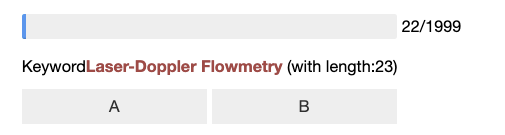

### Review the label result

In [38]:
lbl.df.head()

,keyword,length,options,label
0,Appetite Regulation,19,"[A, B]",A
1,Hymecromone,11,"[A, B]",B
2,Round Ligament of Uterus,24,"[A, B]",A
3,Sugar Acids,11,"[A, B]",B
4,Nogalamycin,11,"[A, B]",B


## Editable list and editable dict

In [ ]:
# export
total_width = Layout(width="100%")


class EditableList(VBox):
    """
    Interactive list
    You can add item to the list
    Each added item has a remove button to remove such item
    """

    def __init__(self, data_list: List[Any] = [], pretty_json: bool = True):
        super().__init__([], layout=total_width)
        self.pretty_json = pretty_json
        for data in data_list:
            self+data

    def create_line(self, data):
        children = list(self.children)
        children.append(self.new_line(data))
        self.children = children

    def data_to_dom(self, data):
        if self.pretty_json:
            pretty = list_group_kv(data) if hasattr(
                data, "keys") else list_group(data)
            return HTML(str(pretty), layout=total_width)
        else:
            return HTML(json.dumps(data))

    def new_line(self, data) -> HBox:
        del_btn = Button(description="Remove", icon="trash")
        del_btn.button_style = 'danger'
        hbox = HBox([del_btn, self.data_to_dom(data)],
                    layout=total_width, box_style='info')
        hbox.data = data

        def remove_hbox():
            children = list(self.children)
            for i, c in enumerate(children):
                if id(c) == id(hbox):
                    children.remove(c)
            self.children = children
        del_btn.click = remove_hbox
        return hbox

    def __add__(self, data):
        self.create_line(data)
        return self

    def get_data(self) -> List[Any]:
        """
        Return the data of this list
        """
        return list(x.data for x in self.children)


class EditableDict(VBox):
    """
    Interactive dictionary
    You can add item to the dictionary
    Each added item has a remove button to remove such item
    """
    def __init__(self, data_dict: Dict[str, Any] = dict(), pretty_json: bool = True):
        super().__init__([], layout=total_width)
        self.pretty_json = pretty_json
        self+data_dict
        
    def on_update(self, func):
        """
        A decorator to set a function
        Every time the dict changed
        Will execute this function
        the default arg is the dictionary data
        """
        self.update_func = func
        return func
    
    def run_update(self):
        if hasattr(self, "update_func"):
            self.update_func(self.get_data())
        
    def create_line(self, key: str, data: Any):
        children_map = dict((child.key, child) for child in self.children)
        children_map[key] = self.new_line(key, data)
        self.children = list(children_map.values())
        self.run_update()
        
    def data_to_dom(self, data):
        if self.pretty_json:
            pretty = list_group_kv(data) if hasattr(
                data, "keys") else list_group(data)
            return HTML(str(pretty), layout=total_width)
        else:
            return HTML(json.dumps(data))

    def new_line(self, key: str, data: Any) -> HBox:
        del_btn = Button(description="Remove", icon="trash")
        del_btn.button_style = 'danger'
        key_info = HTML(f"<h4 class='text-primary p-1'>{key}</h4>")
        hbox = HBox([VBox([key_info, del_btn]), self.data_to_dom(data)],
                    layout=total_width, box_style='')
        hbox.data = data
        hbox.key = key

        def remove_hbox():
            children = list(self.children)
            for c in children:
                if id(c) == id(hbox):
                    children.remove(c)
            self.children = children
            self.run_update()
        del_btn.click = remove_hbox
        return hbox
    
    def __setitem__(self, k, v):
        self.create_line(k, v)
    
    def __add__(self, kv):
        for k,v in kv.items():
            self.create_line(k, v)
        return self

    def get_data(self) -> Dict[str, Any]:
        """
        Return the data of this dict
        """
        return dict((x.key,x.data) for x in self.children)

## Step by step

In [10]:
# export
class LivingStep:
    """
    A step interactive for StepByStep
    """

    def __init__(
        self, func: Callable,
        top_block: HTML = None
    ):
        self.output = Output()
        self.func = func
        self.top_block = top_block

    def __call__(self, **kwargs):
        with self.output:
            if self.top_block is not None:
                display(self.top_block)
            return self.func(**kwargs)

    def new_top_block(self, top_block):
        self.top_block = top_block


class StepByStep:
    """
    A tool to manage progress step by step
    """

    def __init__(
        self,
        funcs: Dict[str, Callable],
        top_board: HTML = None,
        kwargs: Dict[str, Any] = dict()
    ):
        self.step_keys: List[str] = list(funcs.keys())
        self.steps: Dict[str, LivingStep] = dict(
            (k, LivingStep(f)) for k, f in funcs.items())
        self.furthest: int = 0
        self.current: int = -1
        self.kwargs: Dict[str, Any] = kwargs
        self.execute_cache: Dict[str, bool] = dict()
        self.top_board: HTML = top_board
        self.page_output: Output = Output()
        self.footer: Output = Output()
        self.create_widget()

    def rerun(self,**kwargs):
        """
        Rerun the current step function
        """
        # find the step
        step: LivingStep = self.steps[self.step_keys[self.current]]
        # clear old output
        step.output.clear_output()
        self.kwargs.update(kwargs)
        step(progress=self, **self.kwargs)

    def create_control_bar(self,):
        self.bar_hbox = list()
        self.next_btn: Button = Button(
            description="Next", icon='check', button_style='info')
        self.rerun_btn = Button(description="Rerun Step",
                                icon='play', button_style='success')
        self.title = HTML(f"<h4 class='text-primary'>Step By Step</h4>")
        self.next_btn.click = self.next_step
        self.rerun_btn.click = self.rerun
        self.bar_hbox.append(self.title)
        self.bar_hbox.append(self.next_btn)
        self.bar_hbox.append(self.rerun_btn)
        return HBox(self.bar_hbox)

    def create_widget(self) -> None:
        self.vbox_list = []
        if self.top_board is not None:
            self.vbox_list.append(self.top_board)
        
        # create buttons for progress axis
        self.progress_btns = dict(
            (k, Button(
                description=f"{i+1}:{k}",
                icon="cube",
                button_style="danger"
                if i <= self.furthest else ""))
            for i, (k, v) in enumerate(self.steps.items())
        )
        # assign action to first button
        first_btn: Button = list(self.progress_btns.values())[0]
        first_btn.click: Callable = self.to_page_action(0)
        self.progress_bar = HBox(list(self.progress_btns.values()))
        
        # assemble the entire widget
        self.vbox_list.append(self.progress_bar)
        self.vbox_list.append(self.create_control_bar())
        self.vbox_list.append(self.page_output)
        self.widget = VBox(self.vbox_list)

    def to_page_action(
        self, page_id: int
    ) -> Callable:
        """
        generate the button click function
        """
        def to_page_func():
            return self[page_id]
        return to_page_func

    def update_furthest(self):
        """
        Update the "furthest mark"
        Also enact the next progress button
        """
        if self.furthest < self.current:
            if self.current < len(self):
                # update even button
                btn = self.progress_btns[self.step_keys[self.current]]
                btn.click = self.to_page_action(
                    self.current)
                btn.button_style = 'danger'
            self.furthest = self.current
            
    def __repr__(self):
        keys = " => ".join(self.step_keys)
        return f"Progress Axis: [{keys}]"

    def __getitem__(self, page_id):
        """
        Display a single page
        """
        if (page_id < 0) or (page_id >= len(self)):
            return
        self.current: int = page_id
        key: str = self.step_keys[page_id]
        step: LivingStep = self.steps[key]
        self.title.value: str = f"<h4 class='text-danger'>Step {page_id+1}: {key}</h4>"
        self.page_output.clear_output()

        with self.page_output:
            display(step.output)
        if key not in self.execute_cache:
            rt = step(progress=self, **self.kwargs)
            if hasattr(rt,"keys"):
                self.kwargs(rt)
            self.execute_cache[key] = True

    def next_step(self, **kwargs):
        self.current += 1
        if self.current >= len(self):
            self.current = 0
        self.update_furthest()
        return self[self.current]

    def __len__(self):
        return len(self.step_keys)

    def __call__(self, **kwargs):
        """
        Start the entire progress widget
        """
        display(self.widget)
        display(self.footer)
        self.kwargs.update(kwargs)
        self.next_step(**self.kwargs)

    def show_in(self, step_name: str) -> Callable:
        """
        A decorator that will make the function
            to show under a specific step window
        """
        step = self.steps[step_name]

        def decorator(func: Callable) -> Callable:
            def wrapper(*args, **kwargs):
                with step.output:
                    return func(*args, **kwargs)
            return wrapper
        return decorator

    def show_footer(self, func: Callable):
        """
        A decorator, where functions excuted
            within this, will be showon under footer
        """
        def wrapper(*args, **kwargs):
            with self.footer:
                return func(*args, **kwargs)
        return wrapper

In [19]:
def test_step(**kwargs):
    @interact
    def show_step_(how_much=[1,2,4,8,16], charactor = ['🍺', '🏺', '🍶','🍷']):
        return pd.DataFrame({"stuff":[charactor*how_much,]*how_much})

In [20]:
sbs = StepByStep(
    {"step1":test_step,"some_step":test_step, "another_step":test_step},
    HTML("""
    <h1>Detail Steps</h1>
    """)
)

In [21]:
sbs()

Output()